In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Capas sin parámetros (como ReLU)

# Crear una red neuronal
---

In [0]:
# Una red es una clase que hereda de nn.Module (torch.nn.Module)
class Net (nn.Module):
  def __init__(self, num_channels):
    super(Net, self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels * 2, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(self.num_channels * 2, self.num_channels * 4, 3, stride=1, padding=1)

    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self, x):
    # Empezamos con un x de 3 x 64 x 64
    x = self.conv1(x) # num_channels x 64 x 64

    # max_pool2d divide el tamaño de la matriz por el segundo argumento
    x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32

    x = self.conv2(x) # num_channels*2 x 32 x 32
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*2 x 16 x 16
    x = self.conv3(x) # num_channels*4 x 16 x 16
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

    # view transforma el tamaño del tensor. Con -1 es como decir flatten
    x = x.view(-1, self.num_channels*4*8*8)

    # fc (fully connected || Linear)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    # Log softmax para probabilidades
    x = F.log_softmax(x, dim=1)

    return x

# Traer datos con Pytorch
---

In [29]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [30]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [0]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [0]:
from plot_helpers import imshow

In [0]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split='train', transform=None):
    path = os.path.join(base_dir, f'{split}_signs')
    files = os.listdir(path)

    self.filenames = [os.path.join(path, f) for f in files if f.endswith('.jpg')]

    self.targets = [int(f[0]) for f in files]

    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [0]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='train')

In [35]:
len(signs)

864

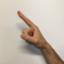

In [36]:
signs[0][0]

# Métodos para entrenar red neuronal
---

## Data loader

In [0]:
import torchvision.transforms as transforms # Coleccion de funciones de preprocesamiento

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='train', transform=transforms.ToTensor())

In [0]:
dataloader = DataLoader(trainset, batch_size=32)

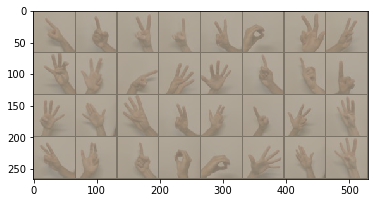

tensor([1, 1, 2, 1, 2, 0, 3, 2, 4, 3, 1, 4, 5, 1, 1, 1, 4, 5, 4, 2, 3, 1, 3, 4,
        2, 3, 1, 0, 0, 5, 5, 4])


In [40]:
from torchvision.utils import make_grid
for inputs, target in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(target)
  break

## Entrenamiento

In [0]:
import torch.optim as optim # Métodos de optimizacion

In [0]:
device = torch.device('cuda')

In [0]:
net = Net(32).to(device)

In [0]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [0]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0

  def update(self, val, size):
    self.S += val
    self.N += size

  def __call__(self):
    return self.S/float(self.N)

# Entrenar red neuronal
---

In [0]:
num_epochs = 100

In [47]:
for epoch in range(num_epochs):
  print(f'Epoch: {epoch + 1}/{num_epochs}')
  print('='*10)

  running_loss = RunningMetric() # Tasa de error (pérdida)
  running_acc = RunningMetric() # Tasa de precisión

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device) # Convertir a GPU

    optimizer.zero_grad() # Resetear gradientes a cero

    outputs = net(inputs) # Calcular salidas
    _, preds = torch.max(outputs, 1) # Calcular las predicciones segun el porcentaje maximo
    loss = loss_fn(outputs, targets) # Calcular las pérdidad

    loss.backward() # Gradientes calculados
    optimizer.step() # Actualiza los parámetros

  # Estadísticas
  batch_size = inputs.size()[0]
  running_loss.update(loss.item() * batch_size, batch_size)
  running_acc.update(torch.sum(preds == targets).float(), batch_size)
  print('Loss: {:.4f} Accuracy: {:.4f}'.format(running_loss(), running_acc()))

Epoch: 1/100
Loss: 1.8025 Accuracy: 0.0938
Epoch: 2/100
Loss: 1.7986 Accuracy: 0.0938
Epoch: 3/100
Loss: 1.7965 Accuracy: 0.0938
Epoch: 4/100
Loss: 1.7949 Accuracy: 0.1250
Epoch: 5/100
Loss: 1.7935 Accuracy: 0.1562
Epoch: 6/100
Loss: 1.7922 Accuracy: 0.1562
Epoch: 7/100
Loss: 1.7912 Accuracy: 0.1562
Epoch: 8/100
Loss: 1.7903 Accuracy: 0.1562
Epoch: 9/100
Loss: 1.7895 Accuracy: 0.1562
Epoch: 10/100
Loss: 1.7886 Accuracy: 0.1562
Epoch: 11/100
Loss: 1.7878 Accuracy: 0.1562
Epoch: 12/100
Loss: 1.7869 Accuracy: 0.1562
Epoch: 13/100
Loss: 1.7860 Accuracy: 0.1562
Epoch: 14/100
Loss: 1.7851 Accuracy: 0.1562
Epoch: 15/100
Loss: 1.7840 Accuracy: 0.1562
Epoch: 16/100
Loss: 1.7828 Accuracy: 0.1562
Epoch: 17/100
Loss: 1.7815 Accuracy: 0.1562
Epoch: 18/100
Loss: 1.7800 Accuracy: 0.1562
Epoch: 19/100
Loss: 1.7785 Accuracy: 0.1562
Epoch: 20/100
Loss: 1.7765 Accuracy: 0.1875
Epoch: 21/100
Loss: 1.7741 Accuracy: 0.1875
Epoch: 22/100
Loss: 1.7713 Accuracy: 0.1875
Epoch: 23/100
Loss: 1.7680 Accuracy: 0.18

# Autograd y métodos de optimización
---

## Autograd

In [53]:
x = torch.Tensor(2)

print(x.requires_grad)
x.requires_grad = True # Utiliza gradientes

loss = 13 * x[0] + 7*x[1] + 1
loss.backward() # Calcular gradientes
print(x)
print(x.grad) # Gradiente resultante

False
tensor([1.6997e-35, 0.0000e+00], requires_grad=True)
tensor([13.,  7.])


In [54]:
x = torch.randn((2, 3), requires_grad=True)
y = torch.Tensor([[1, 2], [3, 4]])
loss = y.mm(x)
loss = loss.sum()
loss.backward()
print(x.grad)

tensor([[4., 4., 4.],
        [6., 6., 6.]])


In [0]:
train = True
with torch.set_grad_enabled(True):
  # Cómputos con tensores
  pass

## Calificación de métodos de optimización

In [0]:
import optimizers_viz as optviz

In [61]:
problem = optviz.build_beales_problem()
constructors = optviz.build_optimizers(problem.lr)
params = optviz.build_params(problem)

WARN: your minima is not the true minima 2.1143495344479093 0.14697613753523747


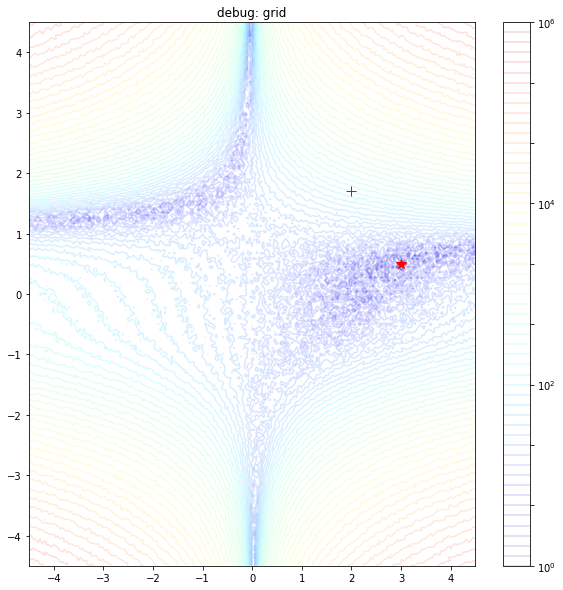

In [62]:
optviz.plot_minimized_function(params)

In [63]:
# Optimizadores a probar
constructors

{'Adadelta': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'Adagrad': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'Adam': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'Adamax': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'RMSprop': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'SGD': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'momentum': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'momentum_dampen': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'nesterov': <function optimizers_viz.build_optimizers.<locals>.<lambda>>,
 'nesterov_decay': <function optimizers_viz.build_optimizers.<locals>.<lambda>>}

In [64]:
zpaths, results, distance, lrs = optviz.run_optimizers(problem, constructors, params)


SGD 171.6614879315328 	 True 	 False
momentum 166.3063541807788 	 True 	 False
momentum_dampen 175.45515294531904 	 True 	 False
nesterov 170.54395167789875 	 True 	 False
nesterov_decay 172.62479665261367 	 True 	 False
Adadelta 177.8611469333609 	 True 	 False
Adagrad 176.7951825029195 	 True 	 False
Adamax 174.51134566668938 	 True 	 False
RMSprop 176.52286542517726 	 True 	 False
Adam 179.4235817034339 	 True 	 False


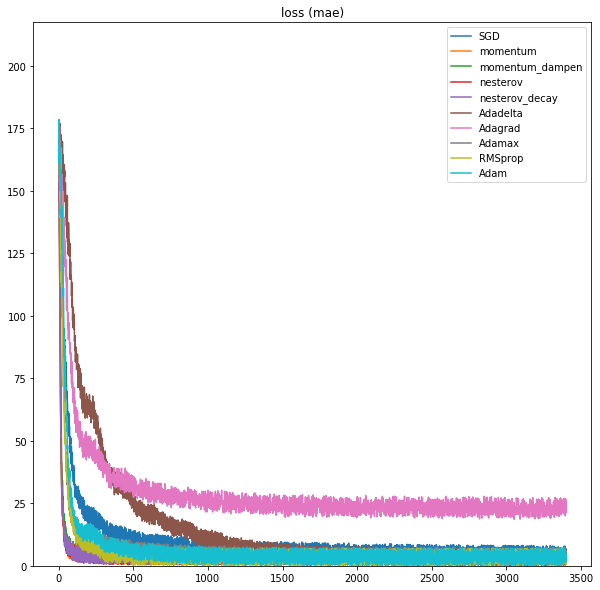

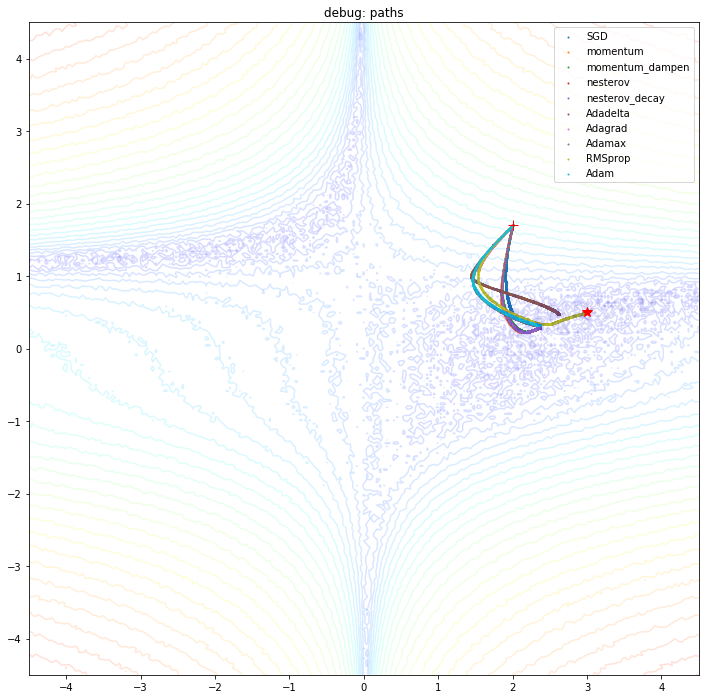

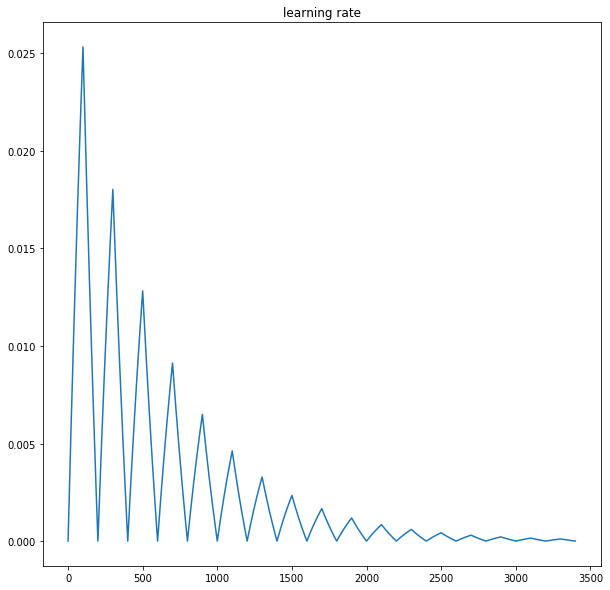

In [65]:
optviz.plot_optim_journeys(zpaths, results, distance, lrs, params)

# Evaluar performance de un modelo
---

## Dataloaders

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='train', transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=32)

valset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='val', transform=transforms.ToTensor())
valloader = DataLoader(valset, batch_size=32)

testset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='test', transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=32)

In [0]:
dataloaders = {
    'train': trainloader,
    'test': testloader,
    'val': valloader
}

## Métodos de regularización

In [0]:
# Data augmentation (en cada epoch aleatoriamente las imagenes tendrán un horizontal flip)
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(), # Data augmentation
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='train', transform=transform)
trainloader = DataLoader(trainset, batch_size=32)

valset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='val', transform=transform)
valloader = DataLoader(valset, batch_size=32)

testset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='test', transform=transform)
testloader = DataLoader(testset, batch_size=32)

dataloaders = {
    'train': trainloader,
    'test': testloader,
    'val': valloader
}

In [0]:
# Batch norm y dropout
class Net (nn.Module):
  def __init__(self, num_channels):
    super(Net, self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(self.num_channels) # Batch norm
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels * 2, 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(self.num_channels * 2) # Batch norm
    self.conv3 = nn.Conv2d(self.num_channels * 2, self.num_channels * 4, 3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(self.num_channels * 4) # Batch norm

    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fcbn1 = nn.BatchNorm1d(self.num_channels*4) # Batch norm (para fully connected)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self, x):
    x = self.bn1(self.conv1(x))
    x = F.relu(F.max_pool2d(x, 2))

    x = self.bn2(self.conv2(x))
    x = F.relu(F.max_pool2d(x, 2))

    x = self.bn3(self.conv3(x))
    x = F.relu(F.max_pool2d(x, 2))

    x = x.view(-1, self.num_channels*4*8*8)

    x = F.relu(self.fcbn1(self.fc1(x)))

    x = self.fc2(x)
    x = F.dropout(x, p=0.8, training=True) # Dropout (desactivar neuronas aleatoriamente)
    x = F.log_softmax(x, dim=1)

    return x

In [0]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epochs=10, lr=0.001):

  # Modificar el lr del optimizer sin tener que volverlo a instanciar
  for g in optimizer.param_groups:
    g['lr'] = lr

  for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1}/{num_epochs}')
    print('='*10)

    # Cambiar el modo del modelo según la fase actual
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = RunningMetric()
      running_acc = RunningMetric()

      for inputs, targets in dataloaders[phase]:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = net(inputs)
          _, preds = torch.max(outputs, 1)
          loss = loss_fn(outputs, targets)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        # Estadísticas
        batch_size = inputs.size()[0]
        running_loss.update(loss.item() * batch_size, batch_size)
        running_acc.update(torch.sum(preds == targets).float(), batch_size)
      print('Loss: {:.4f} Accuracy: {:.4f}'.format(running_loss(), running_acc()))
  return model

In [0]:
import random
lrs = [10 ** (-random.randint(3, 7)) for _ in range(3)]

In [94]:
for lr in lrs:
  print(lr, '-'*20)
  train_and_evaluate(net, optimizer, loss_fn, dataloaders, device, 10, lr)

0.001 --------------------
Epoch: 1/10
Loss: 0.4115 Accuracy: 0.8542
Loss: 0.5636 Accuracy: 0.8148
Epoch: 2/10
Loss: 0.4346 Accuracy: 0.8380
Loss: 0.4797 Accuracy: 0.8565
Epoch: 3/10
Loss: 0.3813 Accuracy: 0.8646
Loss: 0.4359 Accuracy: 0.8519
Epoch: 4/10
Loss: 0.3534 Accuracy: 0.8750
Loss: 0.4523 Accuracy: 0.8426
Epoch: 5/10
Loss: 0.3400 Accuracy: 0.8889
Loss: 0.4330 Accuracy: 0.8704
Epoch: 6/10
Loss: 0.3173 Accuracy: 0.8900
Loss: 0.3939 Accuracy: 0.8657
Epoch: 7/10
Loss: 0.2651 Accuracy: 0.9144
Loss: 0.3969 Accuracy: 0.8519
Epoch: 8/10
Loss: 0.2421 Accuracy: 0.9167
Loss: 0.3285 Accuracy: 0.8796
Epoch: 9/10
Loss: 0.1947 Accuracy: 0.9444
Loss: 0.3727 Accuracy: 0.8843
Epoch: 10/10
Loss: 0.1843 Accuracy: 0.9525
Loss: 0.3827 Accuracy: 0.8843
1e-05 --------------------
Epoch: 1/10
Loss: 0.1844 Accuracy: 0.9363
Loss: 0.3546 Accuracy: 0.8704
Epoch: 2/10
Loss: 0.1556 Accuracy: 0.9560
Loss: 0.3241 Accuracy: 0.8981
Epoch: 3/10
Loss: 0.1393 Accuracy: 0.9664
Loss: 0.3207 Accuracy: 0.8935
Epoch: 4/